# Risk 3:
Even though we aim to de-identify sensitive disease data, since we are focusing on rare diseases it might be possible to cross reference other data sources to re-identify the data, or even reconstruct specific data about an individual given just aggregate statistics.

## Experiment Description:
We would like to determine what data features need to be removed in order to effectively eliminate the risk of re-identifying data, while still enabling effective data analysis. The first step is to simulate a dataset of fully identified rare disease data. We have to simulate this data due to time constraints of the semester and legal issues of acquiring identified health data. Next step is to develop a model to predict the disease type from the data. We will use this model to assess if we can still derive insights from the data when we de-identify the dataset. Next step is to remove features and add noise to the data. There are researched methods to add noise to the data in an optimal way to prevent re-identification. Given the updated dataset, we will attempt to cross reference the original census data to identify each patient’s name and location, and run the predictive model to see if accuracy drops a significant amount. This experiment is essentially testing ways to implement differential privacy on our healthcare data.

Differential privacy is a rigorous mathematical definition of privacy. In the simplest setting, consider an algorithm that analyzes a dataset and computes statistics about it (such as the data's mean, variance, median, mode, etc.). Such an algorithm is said to be differentially private if by looking at the output, one cannot tell whether any individual's data was included in the original dataset or not. In other words, the guarantee of a differentially private algorithm is that its behavior hardly changes when a single individual joins or leaves the dataset -- anything the algorithm might output on a database containing some individual's information is almost as likely to have come from a database without that individual's information. Most notably, this guarantee holds for any individual and any dataset. Therefore, regardless of how eccentric any single individual's details are, and regardless of the details of anyone else in the database, the guarantee of differential privacy still holds. This gives a formal guarantee that individual-level information about participants in the database is not leaked. (https://privacytools.seas.harvard.edu/differential-privacy)

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Part 1 - Prepare data:
We start by loading the first 10000 rows of our simulated health database.

In [141]:
db = pd.read_csv('data/health_database.csv').iloc[:10000] # load our simulated dataset, only first 10000
crossref_db = pd.read_csv('data/crossref_database.csv')

In [4]:
db.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,name,loc
0,52.0,1.0,0.0,125.0,212.0,0.0,1.0,168.0,0.0,1.0,2.0,2.0,3.0,Todd Mckee,"18594 Thomas Plains Suite 308\nCarlosstad, MN ..."
1,53.0,1.0,0.0,140.0,203.0,1.0,0.0,155.0,1.0,3.1,0.0,0.0,3.0,Robert Edwards,"89823 Pierce Fields\nNorth Jessica, CA 89802"
2,70.0,1.0,0.0,145.0,174.0,0.0,1.0,125.0,1.0,2.6,0.0,0.0,3.0,Juan Orr,"5058 Anderson Rest Apt. 213\nNorth Leeberg, CA..."
3,61.0,1.0,0.0,148.0,203.0,0.0,1.0,161.0,0.0,0.0,2.0,1.0,3.0,Dalton Martinez,"9000 Daniels Crescent\nPort Kari, MD 86141"
4,62.0,0.0,0.0,138.0,294.0,1.0,1.0,106.0,0.0,1.9,1.0,3.0,2.0,Lisa Odom,"49017 Matthew Fork\nWest Zachary, LA 59512"


In [5]:
db.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,54.281300,0.699400,0.951600,132.007000,246.730100,0.145600,0.526300,149.369700,0.334400,1.061910,1.369400,0.768800,2.330100
std,9.038393,0.458542,1.034294,17.826063,50.907752,0.352722,0.523389,23.195746,0.471804,1.157512,0.614151,1.043961,0.625918
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.000000,0.000000,0.000000,120.000000,212.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,56.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,167.000000,1.000000,1.800000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


In [142]:
crossref_db.head()

,sex,age,name,loc,ssn
0,1.0,66.0,Michael Torres,"1669 Jason Mission\nAndrewsfurt, MA 86213",678-75-2574
1,0.0,54.0,Sydney Nelson,Unit 7440 Box 8171\nDPO AE 12481,730-33-3009
2,1.0,49.0,Samuel Yang,"78111 Lewis Crossing\nSouth Joseph, GU 78223",831-48-4567
3,0.0,34.0,Sharon Brown,"915 Kristina Points\nKathleenmouth, KS 92956",520-23-3031
4,0.0,52.0,Lisa Richardson,"1490 Taylor Road Apt. 474\nSouth Patrick, ID 2...",390-43-7852


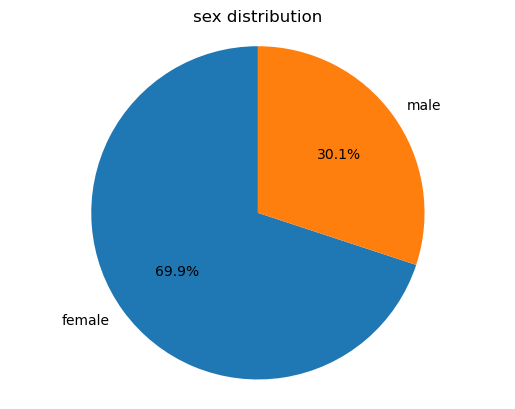

In [136]:
fig1, ax1 = plt.subplots()
ax1.pie(db['sex'].value_counts(), explode=(0,0), labels=['female', 'male'], autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.title('sex distribution')
plt.show()

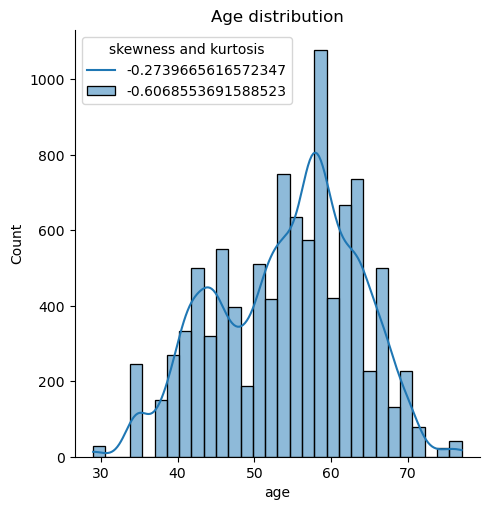

In [138]:
sns.displot(x='age', data=db, bins=30, kde=True)
skewness = str(db["age"].skew())
kurtosis = str(db["age"].kurt())
plt.legend([skewness, kurtosis], title=("skewness and kurtosis"))
plt.title('Age distribution')
plt.show()

### Parallel Databases
Key to the definition of differential privacy is the ability to ask the question "When querying a database, if I removed someone from the database, would the output of the query be any different?". In order to check this, we must construct what we term "parallel databases" which are simply databases with one entry removed.


In [29]:
def get_parallel_db(db, remove_index):
    return pd.concat((
        db.iloc[0:remove_index],
        db.iloc[remove_index+1:],
    ))

# generate list of parallel databases with one row removed
def get_parallel_dbs(db):
    parallel_dbs = []
    for i in range(len(db)):
        parallel_dbs.append(
            get_parallel_db(db, i)
        )

    return parallel_dbs


In [30]:
pdbs = get_parallel_dbs(db)

## Part 2 - Evaluating privacy of different queries on the database

We evaluate the effectiveness of our differential privacy method by calculating the sensitivity, i.e. the impact a change in the underlying data can have on the result of the query (high numbers = bad).

In [11]:
def sensitivity(query):
    full_db_result = query(db.to_numpy())
    max_distance = 0
    for pdb in pdbs:
        pdb_result = query(pdb.to_numpy())

        db_distance = np.abs(pdb_result - full_db_result)
        if (np.max(db_distance) > max_distance):
            max_distance = db_distance

    return max_distance


In [13]:
queries = {
	'mean': np.mean,
	'std': np.std,
	'sum': np.sum,
}

for name, query in queries.items():
	print(f'{name.capitalize()} sensitivity: {sensitivity(query)}')

Mean sensitivity: 0.002768156738746086
Std sensitivity: 0.011431044208023877
Sum sensitivity: 950.3999999994412


## Part 3 - Differential privacy attack example
Here we recover the sex and age of the 100th user in the dataset to show why differential privacy is important (i.e. removing features isn't enough to guarentee privacy)

In [36]:
print(f"age: {db.iloc[100]['age']}, sex: {'male' if db.iloc[100]['sex'] else 'female'}")

age: 43.0, sex: female


In [32]:
pdb = get_parallel_db(db, remove_index=100)

In [37]:
recovered_age = np.sum(db['age']) - np.sum(pdb['age'])
recovered_sex = np.sum(db['sex']) - np.sum(pdb['sex'])
print(f"Recovered age: {recovered_age}, recovered sex: {'male' if recovered_sex else 'female'}")

Recovered age: 43.0, recovered sex: female


In [38]:
# also works with mean
recovered_age = (np.mean(db['age']) - np.sum(pdb['age'])/len(db['age']))*len(db['age'])
recovered_sex = (np.mean(db['sex']) - np.sum(pdb['sex'])/len(db['sex']))*len(db['sex'])
print(f"Recovered age: {recovered_age}, recovered sex: {'male' if recovered_sex else 'female'}")

Recovered age: 43.00000000000637, recovered sex: female


### Result
We can recover the age and sex of any individual in our dataset just using aggregate statistics. Using just this and maybe one or two other reconstructed features, we can possibly cross reference public census data to get the name and location of this individual.

## Part 4 - Local differential privacy
### Plausible deniability

Add randomness to each person's response by giving each person the following instructions:

* Flip a coin 2 times.
* If the first coin flip is heads, answer honestly
* If the first coin flip is tails, answer according to the second coin flip (heads for yes, tails for no)!

Thus, each person is now protected with "plausible deniability." As an example, if we ask the question "have you committed X crime?" and they answer "Yes", then it might because they actually did, or it might be because they are answering according to a random coin flip. Each person has a high degree of protection. Furthermore, we can recover the underlying statistics with some accuracy, as the "true statistics" are simply averaged with a 50% probability. Thus, if we collect a bunch of samples and it turns out that 60% of people answer yes, then we know that the TRUE distribution is actually centered around 70%, because 70% averaged with 50% is 60%.

However, it should be noted that, especially when we only have a few samples, this comes at the cost of accuracy. The greater the privacy protection (plausible deniability) the less accurate the results.

In [103]:
def local_privacy_query(column, db, noise=0.5):
    # local differential privacy
    true_result = db[column].iloc[-1]
    true_query_result = np.mean(db[column])

    first_coin_flip = np.random.rand(len(db)) < noise
    second_coin_flip = np.random.rand(len(db)) < 0.5

    augmented_db = db[column] * first_coin_flip + (1 - first_coin_flip) * second_coin_flip
    sk_result = augmented_db.mean()
    private_query_result = ((sk_result / noise) - 0.5) * noise / (1 - noise)

    # try same differential privacy attack using aggregate statistics
    pdb = get_parallel_db(db, remove_index=-1)
    first_coin_flip = np.random.rand(len(pdb)) < 0.5
    second_coin_flip = np.random.rand(len(pdb)) < 0.5

    augmented_pdb = pdb[column] * first_coin_flip + (1 - first_coin_flip) * second_coin_flip
    sk_parallel_result = augmented_pdb.mean()
    private_parallel_query_result = ((sk_parallel_result / noise) - 0.5) * noise / (1 - noise)
    recovered = (np.mean(db[column]) - np.sum(augmented_pdb)/len(db[column]))*len(db[column])
    return private_query_result, true_query_result, true_result, recovered

In [108]:
for size in [10, 100, 1000, 10000]:
	for noise in np.arange(0.1, 1.0, 0.2):
		private_query_result, true_query_result, true_result, recovered = local_privacy_query('chol', db.iloc[:size], noise=noise)
		print(f"DB size: {size:>5}, noise: {noise:.1f}, True mean cholestorol: {true_query_result:.2f}, Privatized mean cholestorol: {private_query_result:>8.3f}, Cholestorol for last individual: {true_result}, Cholestorol recovery attempt: {recovered}")

DB size:    10, noise: 0.1, True mean cholestorol: 247.60, Privatized mean cholestorol:    0.500, Cholestorol for last individual: 286.0, Cholestorol recovery attempt: -52.00000000000017
DB size:    10, noise: 0.3, True mean cholestorol: 247.60, Privatized mean cholestorol:  180.214, Cholestorol for last individual: 286.0, Cholestorol recovery attempt: -521.0
DB size:    10, noise: 0.5, True mean cholestorol: 247.60, Privatized mean cholestorol:  337.500, Cholestorol for last individual: 286.0, Cholestorol recovery attempt: -84.00000000000006
DB size:    10, noise: 0.7, True mean cholestorol: 247.60, Privatized mean cholestorol:  661.167, Cholestorol for last individual: 286.0, Cholestorol recovery attempt: 732.9999999999998
DB size:    10, noise: 0.9, True mean cholestorol: 247.60, Privatized mean cholestorol: 2223.500, Cholestorol for last individual: 286.0, Cholestorol recovery attempt: 707.9999999999998
DB size:   100, noise: 0.1, True mean cholestorol: 237.01, Privatized mean chol

### Results:
We can see that adding local noise is effective in preventing the same sort of differential privacy attack we saw before, however this can come at a huge cost in accuracy on aggregate statistics for the dataset, depending on the size of the dataset and the amount of noise introduced. Based off the table however, we can deduce that the optimal threshold of noise is generally 0.5, and the difference in accuracy decreases as the size of the dataset increases.

## Part 5 - Global differential privacy
The previous method of adding noise was called "Local Differential Privacy" because we added noise to each datapoint individually. This is necessary for some situations wherein the data is SO sensitive that individuals do not trust noise to be added later. However as shown, it comes at a very high cost in terms of accuracy depending on sample size and the amount of noise added.

Alternatively we can add noise AFTER the data has been aggregated by a function. This kind of noise can allow for similar levels of protection with a lower affect on accuracy. Generally in this case, participants must be able to trust that no one looked at multiple datapoints before the aggregation took place. This is likely not possible with our platform since we are providing raw data streams, however it is still useful to explore in case we decide to offer data analytics in addition to raw data.

### Terms
**Epsilon Zero**: If a query satisfied this inequality where epsilon was set to 0, then that would mean that the query for all parallel databases outputed the exact same value as the full database. 

**Epsilon One**: If a query satisfied this inequality with epsilon 1, then the maximum distance between all queries would be 1, i.e. the maximum distance between the two random distributions M(x) and M(y) is 1 (because all these queries have some amount of randomness in them).

**Delta** is basically the probability that epsilon breaks. 

## Adding noise for global differential privacy
This is about adding noise to the output of our query so that it satisfies a certain epsilon-delta differential privacy threshold.

There are two kinds of noise we can add - Gaussian Noise or Laplacian Noise. For this experiment, we will focus on Laplacian noise since it is generally better than gaussian noise (gaussian noise requires relaxing the differential privacy definition).

We will focus on tuning the Laplacian noise to allow for the greatest privacy. So, how much noise should we add?

The amount of noise necessary to add to the output of a query is a function of four things:
1. the type of noise (Gaussian/Laplacian)
2. the sensitivity of the query/function
3. the desired epsilon (ε)
4. the desired delta (δ)

Laplacian noise is increased/decreased according to a "scale" parameter beta. We choose "beta" based on the following formula.

beta = sensitivity(query) / epsilon

In other words, if we set beta to be this value, then we know that we will have a privacy leakage of <= epsilon. Furthermore, the nice thing about Laplace is that it guarantees this with delta == 0.

In [129]:
epsilon = 0.1
# adds just the right amount of noise such that the query satisfies an epsilon constraint. 
def laplacian_mechanism(db, query, sensitivity):
    beta = sensitivity / epsilon
    noise = np.random.laplace(0, beta, 1)

    return (query(db) + noise)[0]


In [130]:
laplacian_mechanism(db['age'], np.sum, 1)

542848.0160800221

In [131]:
laplacian_mechanism(db['chol'], np.mean, 1/100)

246.65924782415632

# Conclusion
In this experiment we explored different strategies for securing the privacy of patient's data on the HealthifyYou platform using simulated heart disease data. 

In part 3, we showed that it is possible to reconstruct the data for any user when there isn't any differential privacy mechanism.

Next in part 4, we explored local differential privacy, where noise is added randomly to every data point. After running this part, we showed that using a noise threshold of 0.5 is optimal for allowing close aggregate stastics (i.e. the performance of a model trained on the noisy data will not degrade too much), while still ensuring that we aren't able to reconstruct the data for any particular patient. Unfortunately, we also determined that the accuracy of aggregate statistics on the noisy data largely relies on the amount of data too, such that aggregate statistics on a small sample of the noisy dataset is significantly far off the true aggregate.

Lastly in part 5, we experimented with global differential privacy, which is an important concept since it allows for more accurate differential privacy, however it would not fit with our platform since we are providing raw data streams to customers, thus adding noise to queries is effectively meaningless.

### Outcome:
**Use local differential privacy with a noise threshold of 0.5**